# SherLock

### Load Libraries

In [85]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pickle

### Load Data

This will cycle through all the data found in the Kaggle subset data, 'archive'.

#### Functions Required for Non-standard columns

In [33]:
# Functions


#### Loading

In [29]:
# Non-standard columns present, need function to fix
#filename = './archive/AllBroadcasts.csv'
#AllBroadcasts = pd.read_csv(filename, parse_dates=['timestamp'], index_col='timestamp')
#AllBroadcasts.head()

In [30]:
# Non-standard columns present, need function to fix
#filename = './archive/AppPackages.csv'
#AppPackages = pd.read_csv(filename)
#AppPackages.head()

In [10]:
filename = './archive/Bluetooth.csv'
Bluetooth = pd.read_csv(filename, parse_dates=['Bluetooth_timestamp'], index_col='Bluetooth_timestamp')
Bluetooth.head()

,UserID,UUID,Bluetooth_appearance,Bluetooth_class,Bluetooth_mAddress,Bluetooth_mRemoteBrsf,Bluetooth_mValueNREC,Bluetooth_mValueWBS,Bluetooth_name,Bluetooth_rssi
Bluetooth_timestamp,,,,,,,,,,
2016-04-28 00:38:25.529,1461793105533,97bb95f55a,0,5898764,0xE2591A4C3997E31D4BBA5C097862EAA3,NaN,NaN,NaN,0x13791B190947B0A48F1B9A73B1F9E2E0,-102
2016-04-28 00:39:25.616,1461793165621,97bb95f55a,0,5898764,0xE2591A4C3997E31D4BBA5C097862EAA3,NaN,NaN,NaN,0x13791B190947B0A48F1B9A73B1F9E2E0,-101
2016-04-28 00:40:25.688,1461793225711,97bb95f55a,0,5898764,0xE2591A4C3997E31D4BBA5C097862EAA3,NaN,NaN,NaN,0x13791B190947B0A48F1B9A73B1F9E2E0,-103
2016-04-28 00:41:19.453,1461793279457,97bb95f55a,0,5898764,0xE2591A4C3997E31D4BBA5C097862EAA3,NaN,NaN,NaN,0x13791B190947B0A48F1B9A73B1F9E2E0,-100
2016-04-28 00:42:19.435,1461793339441,97bb95f55a,0,5898764,0xE2591A4C3997E31D4BBA5C097862EAA3,NaN,NaN,NaN,0x13791B190947B0A48F1B9A73B1F9E2E0,-101


In [15]:
filename = './archive/Calls.csv'
Calls = pd.read_csv(filename, index_col='UUID')
Calls.head()

,UserId,Address,Date,Duration,FromContacts,Type
UUID,,,,,,
1461843731668,97bb95f55a,c68ad8910c1a649507984b227f2c298140cf593c,1461840872706,562,True,2
1461843731668,97bb95f55a,9ef2cc0b1bd70f3610f022e9807568ae41d87547,1461841935288,103,True,1
1461844038056,97bb95f55a,c68ad8910c1a649507984b227f2c298140cf593c,1461840872706,562,True,2
1461844038056,97bb95f55a,9ef2cc0b1bd70f3610f022e9807568ae41d87547,1461841935288,103,True,1
1461844044062,97bb95f55a,c68ad8910c1a649507984b227f2c298140cf593c,1461840872706,562,True,2


In [13]:
# Non-standard columns present, need function to fix
#filename = './archive/Moriarty.csv'
#Moriarty = pd.read_csv(filename, index_col='UUID')
#Moriarty.head()

In [14]:
filename = './archive/ScreenOn.csv'
ScreenOn = pd.read_csv(filename, parse_dates=['Timestamp'], index_col='UUID')
ScreenOn.head()

,UserID,ScreenOn,Timestamp
UUID,,,
1461799304991,97bb95f55a,True,2016-04-28 02:21:44.991
1461799370983,97bb95f55a,False,2016-04-28 02:22:50.982
1461799535929,97bb95f55a,True,2016-04-28 02:25:35.929
1461799547083,97bb95f55a,False,2016-04-28 02:25:47.083
1461799558976,97bb95f55a,True,2016-04-28 02:25:58.975


In [17]:
filename = './archive/SMS.csv'
SMS = pd.read_csv(filename, index_col='UUID')
SMS.head()

,UserId,Address,ContainsURL,Date,FromContacts,Type
UUID,,,,,,
1462180806299,97bb95f55a,db61c51fb5a33d6e9e9cfb0bd06cfc6fc355aee9,False,1462179703741,True,2
1462217820128,97bb95f55a,06f0f34118867835b064b5c8b0c8a608f63c8833,False,1462217442462,True,2
1462221420765,97bb95f55a,06f0f34118867835b064b5c8b0c8a608f63c8833,False,1462218200141,True,1
1462296548071,97bb95f55a,9ef2cc0b1bd70f3610f022e9807568ae41d87547,False,1462293160068,True,1
1462358045151,97bb95f55a,8c979d3363a08497c97eae271995d0515de3e892,False,1462355719063,True,1


In [21]:
filename = './archive/T0.csv'
T0 = pd.read_csv(filename, parse_dates=['Telephoney_timestemp', 'SystemInfo_timestemp'], index_col='UUID')
T0.head()

,UserId,Version,Telephoney_deviceId,Telephoney_deviceSoftwareVersion,Telephoney_networkCountryIso,Telephoney_networkOperator,Telephoney_networkOperatorName,Telephoney_networkType,Telephoney_phoneType,Telephoney_simCountryIso,...,Hardware_bluetoothMac,Hardware_androidId,Hardware_brand,Hardware_model,Hardware_deviceId,SystemInfo_OS_version,SystemInfo_Baseband_version,SystemInfo_SDK,SystemInfo_KernelInfo,SystemInfo_timestemp
UUID,,,,,,,,,,,,,,,,,,,,,
1461810132306,97bb95f55a,2.2,0xC9BBAB88E558ED78B9AF59E2EA080B8C,1,0x18BF4E84F52AB0B82731630D8AECB00D,0xD688B06448E02689744497E83A796106,0x2BEED070F9F696EB4E7162FC1B90CE30,10,1,0x18BF4E84F52AB0B82731630D8AECB00D,...,0x69FA71A8F27789579667C1D2D172EB3E,5ce1475af1675e4c,samsung,SM-G900F,0xC9BBAB88E558ED78B9AF59E2EA080B8C,5.0,G900FXXU1BOE3,21,Linux version 3.4.0-4872298 (dpi@SWDD3921) (gc...,2016-04-28 04:22:12.226
1461853761332,97bb95f55a,2.2,0xC9BBAB88E558ED78B9AF59E2EA080B8C,1,0x18BF4E84F52AB0B82731630D8AECB00D,0xD688B06448E02689744497E83A796106,0x2BEED070F9F696EB4E7162FC1B90CE30,10,1,0x18BF4E84F52AB0B82731630D8AECB00D,...,0x69FA71A8F27789579667C1D2D172EB3E,5ce1475af1675e4c,samsung,SM-G900F,0xC9BBAB88E558ED78B9AF59E2EA080B8C,5.0,G900FXXU1BOE3,21,Linux version 3.4.0-4872298 (dpi@SWDD3921) (gc...,2016-04-28 16:29:21.320
1461854175049,97bb95f55a,2.2,0xC9BBAB88E558ED78B9AF59E2EA080B8C,1,0x18BF4E84F52AB0B82731630D8AECB00D,0xD688B06448E02689744497E83A796106,0x2BEED070F9F696EB4E7162FC1B90CE30,10,1,0x18BF4E84F52AB0B82731630D8AECB00D,...,0x69FA71A8F27789579667C1D2D172EB3E,5ce1475af1675e4c,samsung,SM-G900F,0xC9BBAB88E558ED78B9AF59E2EA080B8C,5.0,G900FXXU1BOE3,21,Linux version 3.4.0-4872298 (dpi@SWDD3921) (gc...,2016-04-28 17:36:13.733
1462040467954,97bb95f55a,2.2,0xC9BBAB88E558ED78B9AF59E2EA080B8C,1,0x18BF4E84F52AB0B82731630D8AECB00D,0xD688B06448E02689744497E83A796106,0x2BEED070F9F696EB4E7162FC1B90CE30,10,1,0x18BF4E84F52AB0B82731630D8AECB00D,...,0x69FA71A8F27789579667C1D2D172EB3E,5ce1475af1675e4c,samsung,SM-G900F,0xC9BBAB88E558ED78B9AF59E2EA080B8C,5.0,G900FXXU1BOE3,21,Linux version 3.4.0-4872298 (dpi@SWDD3921) (gc...,2016-04-30 20:21:07.848
1462053633470,97bb95f55a,2.2,0xC9BBAB88E558ED78B9AF59E2EA080B8C,1,0x18BF4E84F52AB0B82731630D8AECB00D,0xD688B06448E02689744497E83A796106,0x2BEED070F9F696EB4E7162FC1B90CE30,13,1,0x18BF4E84F52AB0B82731630D8AECB00D,...,0x69FA71A8F27789579667C1D2D172EB3E,5ce1475af1675e4c,samsung,SM-G900F,0xC9BBAB88E558ED78B9AF59E2EA080B8C,5.0,G900FXXU1BOE3,21,Linux version 3.4.0-4872298 (dpi@SWDD3921) (gc...,2016-05-01 00:00:33.483


In [20]:
filename = './archive/T1.csv'
T1 = pd.read_csv(filename, parse_dates=['GooglePlayLoc_timestamp', 'CellTower_timestamp', 'Status_timestamp'], index_col='UUID')
T1.head()

,UserID,Version,GooglePlayLoc_Speed,GooglePlayLoc_mAccuracy,5-means_geo,10-means_geo,25-means_geo,50-means_geo,75-means_geo,100-means_geo,...,Status_Brightness_settings,Status_DtmfVol,Status_MusicVol,Status_NotificationVol,Status_Orientation,Status_RingerMode,Status_RingtoneVol,Status_SystemVol,Status_VoiceCallVol,Status_timestamp
UUID,,,,,,,,,,,,,,,,,,,,,
1461792798919,97bb95f55a,2.2,0.0,25.0,5.0,7.0,3.0,9.0,28.0,66.0,...,65.0,0.0,7.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-04-28 00:33:06.062
1461792858852,97bb95f55a,2.2,0.0,25.0,5.0,7.0,3.0,9.0,28.0,66.0,...,65.0,0.0,7.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-04-28 00:34:05.950
1461792918778,97bb95f55a,2.2,0.0,22.0,5.0,7.0,3.0,9.0,28.0,66.0,...,65.0,0.0,7.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-04-28 00:35:05.928
1461792978911,97bb95f55a,2.2,0.0,24.0,5.0,7.0,3.0,9.0,28.0,66.0,...,65.0,0.0,7.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-04-28 00:36:06.109
1461793039062,97bb95f55a,2.2,0.0,24.0,5.0,7.0,3.0,9.0,28.0,66.0,...,65.0,0.0,7.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-04-28 00:37:06.227


In [36]:
filename = './archive/T2.csv'
T2 = pd.read_csv(filename, parse_dates=['TimeStemp'])
T2.head()

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,UserID,UUID,Version,TimeStemp,AccelerometerStat_x_DC_FFT,AccelerometerStat_x_FIRST_IDX_FFT,AccelerometerStat_x_FIRST_VAL_FFT,AccelerometerStat_x_FOURTH_IDX_FFT,AccelerometerStat_x_FOURTH_VAL_FFT,AccelerometerStat_x_MEAN,...,AccelerometerStat_x_MIDDLE_SAMPLE,AccelerometerStat_y_MIDDLE_SAMPLE,AccelerometerStat_z_MIDDLE_SAMPLE,GyroscopeStat_x_MIDDLE_SAMPLE,GyroscopeStat_y_MIDDLE_SAMPLE,GyroscopeStat_z_MIDDLE_SAMPLE,MagneticField_x_MIDDLE_SAMPLE,MagneticField_y_MIDDLE_SAMPLE,MagneticField_z_MIDDLE_SAMPLE,pressure_MIDDLE_SAMPLE
0,97bb95f55a,1461792775659,2.2,2016-04-28 00:32:55.659,112.709439,256.0,0.070102,254.0,0.079229,-0.557968,...,-0.581192,1.294665,8.746617,-0.010386,-0.007457,-0.007191,-21.90,-9.06,-36.78,991.61770
1,97bb95f55a,1461792795462,2.2,2016-04-28 00:33:15.462,14.500483,256.0,0.010774,232.0,0.168699,-0.074745,...,-0.073622,0.563835,8.868722,-0.011185,-0.008522,-0.007723,-22.74,-7.92,-37.86,991.60010
2,97bb95f55a,1461792815793,2.2,2016-04-28 00:33:35.793,52.429426,256.0,0.021820,254.0,0.042375,-0.268869,...,-0.257377,1.046266,8.807071,-0.009854,-0.007723,-0.008256,-22.32,-9.54,-36.84,991.61670
3,97bb95f55a,1461792835871,2.2,2016-04-28 00:33:55.871,55.027734,256.0,0.023284,254.0,0.030026,-0.267125,...,-0.283713,1.059434,8.812458,-0.010386,-0.006658,-0.008788,-22.32,-9.30,-36.84,991.60767
4,97bb95f55a,1461792855947,2.2,2016-04-28 00:34:15.947,51.626172,256.0,0.017703,254.0,0.036902,-0.266114,...,-0.266954,1.054047,8.789713,-0.008788,-0.007191,-0.009055,-23.10,-9.60,-36.84,991.64870


In [23]:
filename = './archive/T3.csv'
T3 = pd.read_csv(filename, parse_dates=['Audio_timestemp', 'Light_timestamp'], index_col='UUID')
T3.head()

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Userid,version,Audio_diffSecs,Audio_l1Norm,Audio_l2Norm,Audio_linfNorm,AudPSD_AcrossFreqBands0,AudPSD_AcrossFreqBands1,AudPSD_AcrossFreqBands2,AudPSD_AcrossFreqBands3,...,Audio_mfccs6,Audio_mfccs7,Audio_mfccs8,Audio_mfccs9,Audio_mfccs10,Audio_mfccs11,Audio_timestemp,Light_accuracy,Light_lux,Light_timestamp
UUID,,,,,,,,,,,,,,,,,,,,,
1461792780114,97bb95f55a,2.2,1.076,8.839250,11.245488,7.280110,4.967447e+06,6.913792e+05,2.057183e+05,9.494082e+04,...,0.242247,1.056527,-0.279075,-0.080445,0.247651,0.293434,2016-04-28 00:33:00.108,3.0,5.0,2016-04-28 00:35:24
1461792790428,97bb95f55a,2.2,1.076,171.160000,323.600231,47.979162,8.658499e+09,8.147687e+07,8.042797e+06,2.694798e+06,...,-0.190259,1.220309,2.014088,0.748179,1.295779,0.092768,2016-04-28 00:33:10.423,3.0,5.0,2016-04-28 00:35:35
1461792800213,97bb95f55a,2.2,1.070,390.244250,1166.884542,98.696504,1.639047e+11,3.122030e+08,4.303137e+07,6.289338e+06,...,3.143866,1.539534,1.648578,0.510569,-1.603548,-0.825817,2016-04-28 00:33:20.207,3.0,3.0,2016-04-28 00:35:44
1461792810305,97bb95f55a,2.2,1.082,10.661625,13.512601,7.141428,8.111488e+06,7.370618e+05,2.058328e+05,9.477962e+04,...,1.244944,1.190043,0.811302,0.488160,-0.030968,0.857027,2016-04-28 00:33:30.302,3.0,5.0,2016-04-28 00:35:55
1461792820333,97bb95f55a,2.2,1.074,11.884500,16.582227,17.088007,8.879499e+06,1.124284e+06,2.387112e+05,9.156682e+04,...,0.801114,0.616720,0.090023,0.973747,0.719903,0.516113,2016-04-28 00:33:40.328,3.0,5.0,2016-04-28 00:36:05


In [24]:
filename = './archive/T4.csv'
T4 = pd.read_csv(filename, parse_dates=['Traffic_timestamp', 'Battery_timestamp'], index_col='UUID')
T4.head()

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Userid,Version,CpuHertz,CPU_0,CPU_1,CPU_2,CPU_3,Total_CPU,TotalMemory_freeSize,TotalMemory_max_size,...,tot_iowait,tot_irq,tot_softirq,ctxt,btime,processes,procs_running,procs_blocked,connectedWifi_SSID,connectedWifi_Level
UUID,,,,,,,,,,,,,,,,,,,,,
1462793200348,97bb95f55a,2.3.1,1.7 GHz,45.833336,52.380955,80.000000,61.904762,60.029762,8306960.0,536870912.0,...,594356.0,3118.0,1950319.0,1.331499e+09,1.462389e+09,8384093.0,5.0,0.0,0x3352A141D7A60F64879A4235D387F36B,-127.0
1462793205551,97bb95f55a,2.3.1,1.7 GHz,95.238100,5.000000,100.000000,21.052631,55.322680,1740590.0,536870912.0,...,594361.0,3118.0,1950376.0,1.331527e+09,1.462389e+09,8384207.0,4.0,0.0,0x3352A141D7A60F64879A4235D387F36B,-127.0
1462793213783,97bb95f55a,2.3.1,1.7 GHz,72.727270,7.692308,78.947370,4.761905,41.032210,7874128.0,536870912.0,...,594371.0,3118.0,1950496.0,1.331588e+09,1.462389e+09,8384543.0,3.0,0.0,0x3352A141D7A60F64879A4235D387F36B,-127.0
1462793218751,97bb95f55a,2.3.1,1.7 GHz,5.000000,4.761905,4.761905,4.545454,4.767316,12478652.0,536870912.0,...,594373.0,3118.0,1950517.0,1.331603e+09,1.462389e+09,8384623.0,1.0,0.0,0x3352A141D7A60F64879A4235D387F36B,-127.0
1462793223756,97bb95f55a,2.3.1,1.7 GHz,21.739130,0.000000,21.739130,5.000000,12.119565,778458.0,536870912.0,...,594379.0,3118.0,1950554.0,1.331623e+09,1.462389e+09,8384755.0,3.0,0.0,0x3352A141D7A60F64879A4235D387F36B,-127.0


In [26]:
filename = './archive/Wifi.csv'
Wifi = pd.read_csv(filename, index_col='UUID')
Wifi.head()

,UserID,SSID,Capabilities,Freq,Level
UUID,,,,,
1461792798919,97bb95f55a,0x8ED7E0AB909E0B86F79FBA5D3FAAEA88,[WPS][ESS],2437,-78
1461792858852,97bb95f55a,0x8ED7E0AB909E0B86F79FBA5D3FAAEA88,[WPS][ESS],2437,-78
1461792918778,97bb95f55a,0x8ED7E0AB909E0B86F79FBA5D3FAAEA88,[WPS][ESS],2437,-79
1461792978911,97bb95f55a,0x8ED7E0AB909E0B86F79FBA5D3FAAEA88,[WPS][ESS],2437,-80
1461793039062,97bb95f55a,0x8ED7E0AB909E0B86F79FBA5D3FAAEA88,[WPS][ESS],2437,-80


### EDA

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


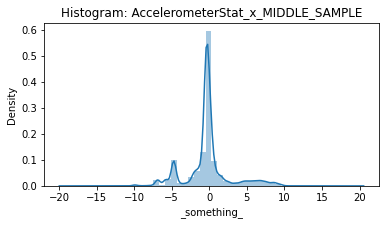

In [43]:
sns.distplot(T2['AccelerometerStat_x_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_x_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


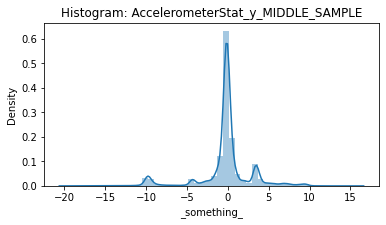

In [44]:
sns.distplot(T2['AccelerometerStat_y_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_y_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


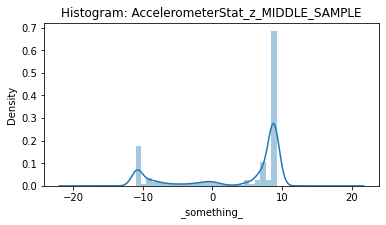

In [45]:
sns.distplot(T2['AccelerometerStat_z_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_z_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


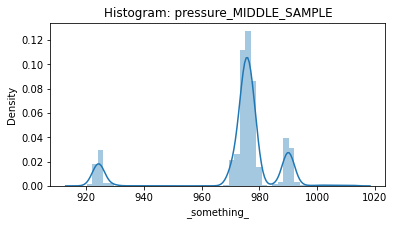

In [46]:
sns.distplot(T2['pressure_MIDDLE_SAMPLE'])
plt.title('Histogram: pressure_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

### Goofy stuff

In [82]:
t2_accelero = T2[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE',
                  'pressure_MIDDLE_SAMPLE']]

t2_accelero.isnull().values.any()
t2_accelero = t2_accelero.dropna()
t2_accelero.isnull().values.any()

t2_accelero_X = t2_accelero[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE']]
t2_accelero_y = t2_accelero[['pressure_MIDDLE_SAMPLE']]

X_train, X_test, y_train, y_test = train_test_split(t2_accelero_X, t2_accelero_y, random_state=42)

### Pipeline for pipeline assignment

In [84]:
pipe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.050263237819209716

Pretty poor, eh?  Well, what would you expect from a random grab...

### Pickle the model

In [86]:
with open('model.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(pipe, f, pickle.HIGHEST_PROTOCOL)

### Create faux-data

In [101]:
print(X_test[0:2].values.tolist())

[[-0.38845924, 0.36272156, 8.802282], [2.2254105, -1.0384849, 8.515577]]
